In [1]:
# fetch the mnist dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# Seperate the features and labels for mnist dataset
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are `70,000 images`, and each image has `784 features`. This is because each image
is `28 × 28` pixels, and each feature simply represents one pixel’s intensity, from `0
(white)` to `255 (black)`

Visualization:

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

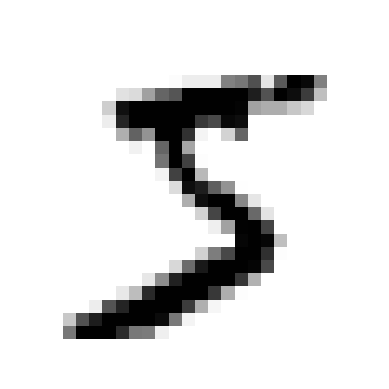

In [6]:
some_digit = X.iloc[0,:].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0] # note that the label here is a string, most ml algorithm need integer.

'5'

In [8]:
# convert the string to integer:

y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

### 5-detector using SGD Classifier

In [10]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Evaluating performance of the model:

### Measuring Accuracy Using Cross-Validation

cross_val_score() function to evaluate our SGDClassifier model

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, 
                X_train,
                y_train_5, 
                cv=3, # kflolds
                scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets

### Confusion Matrix

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predic‐
tions made on each test fold.

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,
                                 X_train, 
                                 y_train_5, 
                                 cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class.

accuracy of the positive pre‐dictions; this is called the `precision` of the classifier

`recall`, also called `sensitivity` or the `true positive rate
(TPR)`: this is the ratio of positive instances that are correctly detected by the classifier

### Precision and Recall:

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

# our model is correct only 83% of the time

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

# our model only detects 65% of 5's correctly

0.6511713705958311

### F1 Score

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1 score is
the `harmonic mean` of precision and recall

regular mean
treats all values equally, the harmonic mean gives much more weight to low values

the classifier will only get a high F1 score if both recall and precision are
high.

2÷((1÷precision)+(1÷recall))

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Precision-Recall: 

PRECISION: Kids video- its okay if I reject many good videos(low recall) along with bad videos. High precision.

RECALL: Shoplifter: its fine to have 30% precisoin as long as I have 99% recall.

THRESHOLD: Scikit-Learn does not let you set the threshold directly, but it does give you access to
the `decision scores` that it uses to make predictions

### decision_function()

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [20]:
# set the threshold 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
# set the threshold 8000
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

raising the threshold decreases recall

### How do you decide which `threshold` to use?

1. First calculate scores for each instance using `cross_val_predict()`

In [22]:
y_scores = cross_val_predict(sgd_clf, 
                             X_train, 
                             y_train_5, 
                             cv=3,
                             method="decision_function") #return decision scores instead of predictions


2. use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  threshold_index = np.argmax(precisions == recalls)
  threshold = thresholds[threshold_index]
  plt.plot([threshold, threshold], [0, 1], "r:")
  plt.legend(loc="center right", fontsize=16)
  plt.xlabel("Threshold", fontsize=16)
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])

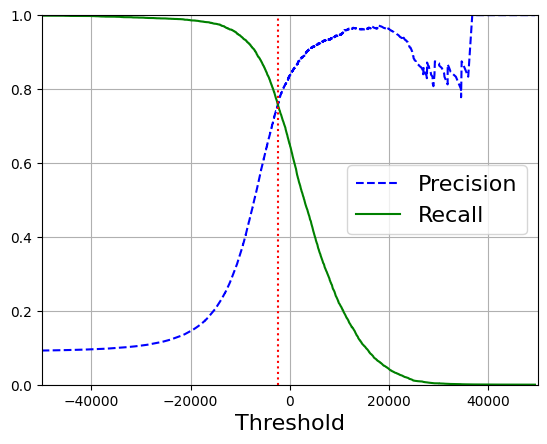

In [25]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly
against recall

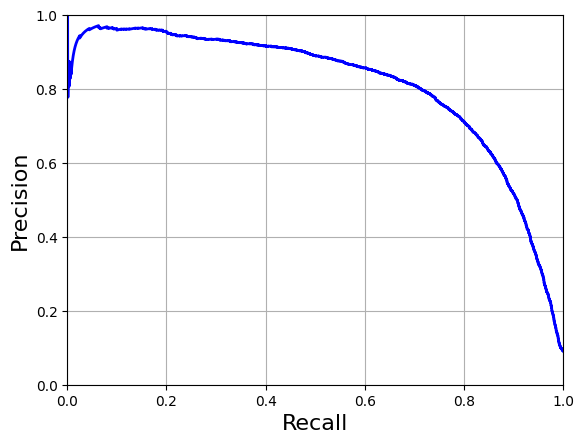

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
plot_precision_vs_recall(precisions, recalls)
plt.show()

precision really starts to fall sharply around 80% recall.

`np.argmax()` will give you the
first index of the maximum value, which in this case means the first True value

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

receiver operating characteristic (ROC)

the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR is the ratio of negative instan‐
ces that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) ver‐
sus 1 – specificity.

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

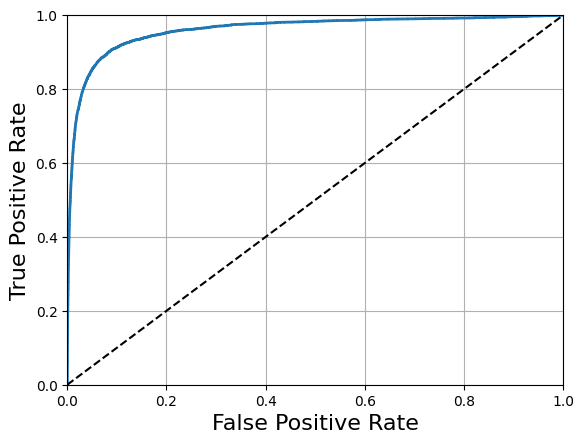

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

A good classifier stays as far away from that line as possible

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve.

## RandomForestClassifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, 
                                    X_train, 
                                    y_train_5, 
                                    cv=3,
                                    method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1]
# score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

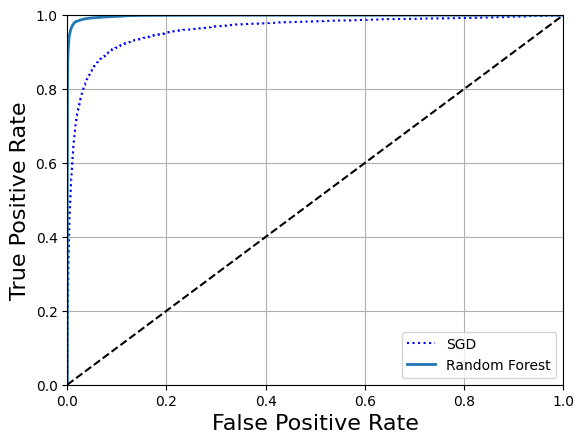

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.

Logistic
Regression or Support Vector Machine classifiers) are strictly binary classifiers.

### one-versus-the-rest (OvR) strategy

classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier out‐
puts the highest score

### one-versus-one (OvO) strategy

train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. train `N × (N – 1) / 2` classifiers.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set. For these algorithms OvO is preferred

## SVM

In [38]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [40]:
# The highest score is indeed the one corresponding to class 5
np.argmax(some_digit_scores)

5

In [41]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## OneVsRest Classifier:

In [42]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC()) # forcing OvR on SVC()
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [43]:
ovr_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

## SGD

In [45]:
## SGD classifiers can directly classify instances into multiple classes

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [46]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Simply scaling the inputs will increase the accuracy:

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis:

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

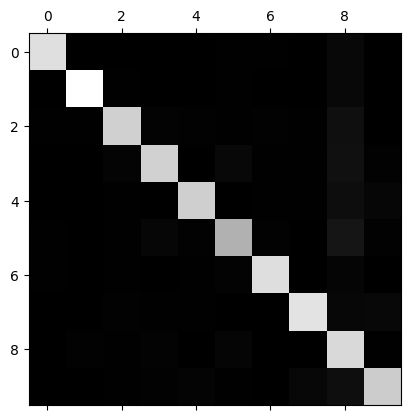

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [52]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9), and the second
indicates whether or not it is odd.

In [53]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [55]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605